In [1]:
#from xgboost import XGBClassifier
import numpy as np
import pandas as pd
import pytorch_lightning as pl
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler, MinMaxScaler 
from sklearn.metrics import precision_score, recall_score, roc_auc_score, accuracy_score
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import random
import torch

E:\Users\anaconda3\envs\py36\lib\site-packages\setuptools\distutils_patch.py:26: UserWarning: Distutils was imported before Setuptools. This usage is discouraged and may exhibit undesirable behaviors or errors. Please use Setuptools' objects directly or at least import Setuptools first.
  "Distutils was imported before Setuptools. This usage is discouraged "


## Preprocess dataset

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000002A36FCC6FD0>,
      dtype=object)

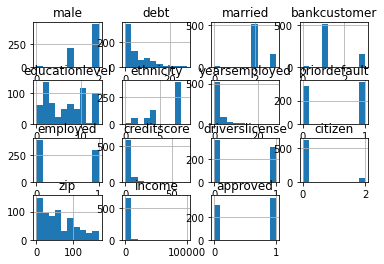

In [13]:
import numpy as np # linear algebra
import pandas as pd 
names = ['male', 'age', 'debt', 'married', 'bankcustomer', 'educationlevel', 'ethnicity', 'yearsemployed',
               'priordefault', 'employed', 'creditscore', 'driverslicense', 'citizen', 'zip', 'income', 'approved']

data = pd.read_csv('./data/credit.csv', header=None,  names=names)
data.reset_index(drop=True, inplace=True) 


data = data.dropna(how = 'all')
data = data[data.age != '?']



from sklearn import preprocessing
for feat in ['male', 'married','bankcustomer', 'educationlevel', 'ethnicity','priordefault', 'employed', 'driverslicense', 'citizen', 'zip', 'approved']:
    data[feat] = preprocessing.LabelEncoder().fit_transform(data[feat])
    
data.head()
data.hist()

## The dag used from paper

In [3]:
# Define DAG for Credit dataset
dag= [    
    # Edges from age
    ['age', 'yearsemployed'],
    
    # Edges from ethnicity
    ['ethnicity', 'approved'],
    ['ethnicity', 'married'],
    
    # Edges from default
    ["priordefault", "creditscore"],
    ["priordefault", "approved"],
    ["priordefault", "employed"],
    
    # Edges from zip
    ["zip", "married"],
    # Edges from citizen
    ["citizen","married"],
    # Edges from driverslicense
    ["driverslicense","employed"],
    # Edges from education_level
    ["educationlevel","employed"],
    ["educationlevel","married"],
    
    # Edges from yearsemployed
    ["yearsemployed", "creditscore"],
    # Edges from creditscore
    ["creditscore", "approved"],
    ["creditscore", "debt"],
    
    # Edges from employed
    ["employed", "bankcustomer"],
    ["employed", "debt"],
    
    # Edges from debt
    ["debt", "income"],
    # Edges from married
    ["married", "approved"],
    
    # Edges from income
    ["income", "approved"],
    ["income", "married"],
]

print(len(dag))
def dag_to_idx(df, dag):
    """Convert columns in a DAG to the corresponding indices."""

    dag_idx = []
    for edge in dag:
        dag_idx.append([df.columns.get_loc(edge[0]), df.columns.get_loc(edge[1])])

    return dag_idx

# Convert the DAG to one that can be provided to the DECAF model
dag_seed = dag_to_idx(data, dag)
print(dag_seed)

20
[[1, 7], [6, 15], [6, 3], [8, 10], [8, 15], [8, 9], [13, 3], [12, 3], [11, 9], [5, 9], [5, 3], [7, 10], [10, 15], [10, 2], [9, 4], [9, 2], [2, 14], [3, 15], [14, 15], [14, 3]]


## Use dag from notebook

In [4]:
#####################################################
#### For this experiment, we uniquely drop the default variable (prior default)
###################################################
#data = data.drop(['educationlevel'], axis=1)
    

from pycausal.pycausal import pycausal as pc
pc = pc()
pc.start_vm()

from pycausal import prior as p
prior = p.knowledge(addtemporal = [['male', 'age','ethnicity'],[ 'debt', 'married', 'bankcustomer', 'educationlevel', 'yearsemployed',
                'employed', 'creditscore', 'driverslicense', 'citizen', 'zip', 'income'],['approved']])


from pycausal import search as s
tetrad = s.tetradrunner()
tetrad.run(algoId = 'fges', scoreId = 'cg-bic-score', dfs = data, priorKnowledge = prior,
           maxDegree = -1, faithfulnessAssumed = True, verbose = False)
tetrad.getEdges()

dag_seed = []
for edge in tetrad.getEdges():
    dag_seed.append(list([names.index(edge.split(' ')[0]), names.index(edge.split(' ')[-1])]))
print(dag_seed )

[[1, 7], [8, 1], [10, 2], [6, 1], [7, 10], [13, 2], [3, 15], [7, 2], [9, 10], [4, 15], [9, 15], [8, 7], [4, 9], [4, 3], [8, 15], [7, 11], [12, 9], [10, 13], [9, 8]]


In [5]:
import pickle 
p_idx = 6
p_attr = 'ethnicity'
#for p in [0, 0.2, 0.4, 0.6, 0.8, 1]:
for p in [0]:
    names = ['male', 'age', 'debt', 'married', 'bankcustomer', 'educationlevel', 'ethnicity', 'yearsemployed',
               'priordefault', 'employed', 'creditscore', 'driverslicense', 'citizen', 'zip', 'income', 'approved']
    data = pd.read_csv('./data/credit.csv', header=None,  names=names)
    data.reset_index(drop=True, inplace=True) 
    data = data.dropna(how = 'all')

    data = data[data.age != '?']
    data.reset_index(drop=True, inplace = True)


    from sklearn import preprocessing
    for feat in ['male', 'married','bankcustomer', 'educationlevel', 'ethnicity','priordefault', 'employed', 'driverslicense', 'citizen', 'zip', 'approved']:
        data[feat] = preprocessing.LabelEncoder().fit_transform(data[feat])

    data['age'] = pd.to_numeric(data['age'],errors='coerce')


    data.loc[data['ethnicity'] <= 4, 'ethnicity'] = 0
    data.loc[data['ethnicity'] > 4, 'ethnicity']= 1
    
    
    data.loc[data['ethnicity'] ==1 , 'employed'] =  1

    biased_data = data.copy()
    
    
    bias = p
    #biased_data.loc[biased_data['ethnicity'] == 1, 'approved'] = np.logical_and(biased_data.loc[biased_data['ethnicity'] == 1, 'approved'].values, 
    #               np.random.binomial(1, bias, len(biased_data.loc[biased_data['ethnicity'] == 1, 'approved']))).astype(int)
    print(biased_data['approved'].value_counts())
    biased_data.head()

    thresh = 0.8

    from sklearn.preprocessing import MinMaxScaler

    scaler = MinMaxScaler()
    scaler.fit(data)
    data[data.columns] = scaler.fit_transform(data)
    biased_data[biased_data.columns] = scaler.transform(biased_data)
    print(biased_data.head)
    import pickle 
    p_idx = 6
    p_attr = 'ethnicity'

    #view_stats_new(['fairgan'], biased_data, protected = p_attr, remove_protected = False,
    #           orig_data = data ,protected_idx = p_idx, bias_dict ={})

    #view_stats_new(['gan', 'wgan', 'adsgan'], biased_data, protected = p_attr, remove_protected = False,
    #           orig_data = data ,protected_idx = p_idx, bias_dict ={})
    
#     view_stats_new(['DECAF'], biased_data, protected = p_attr, remove_protected = False,
#            orig_data = data ,protected_idx = p_idx, bias_dict ={})

#     view_stats_new(['DECAF-FTU1'], biased_data, protected = p_attr, remove_protected = False,
#                orig_data = data ,protected_idx = p_idx, bias_dict ={15:[6]})
    
#     view_stats_new(['DECAF-FTU2'], biased_data, protected = p_attr, remove_protected = False,
#                orig_data = data ,protected_idx = p_idx, bias_dict ={15:[6]}, surrogate = True,)

#     view_stats_new(['DECAF-DP'], biased_data, protected = p_attr, remove_protected = False,
#                orig_data = data ,protected_idx = p_idx, bias_dict ={15:[6,9]})

1    373
0    305
Name: approved, dtype: int64
<bound method NDFrame.head of      male       age      debt   married  bankcustomer  educationlevel  \
0     1.0  0.256842  0.000000  0.666667      0.333333        0.928571   
1     0.5  0.675489  0.159286  0.666667      0.333333        0.785714   
2     0.5  0.161654  0.017857  0.666667      0.333333        0.785714   
3     1.0  0.211729  0.055000  0.666667      0.333333        0.928571   
4     1.0  0.096541  0.200893  0.666667      0.333333        0.928571   
..    ...       ...       ...       ...           ...             ...   
673   1.0  0.110226  0.360179  1.000000      1.000000        0.357143   
674   0.5  0.134135  0.026786  0.666667      0.333333        0.142857   
675   0.5  0.172932  0.482143  1.000000      1.000000        0.428571   
676   1.0  0.062707  0.007321  0.666667      0.333333        0.071429   
677   1.0  0.319549  0.120536  0.666667      0.333333        0.142857   

     ethnicity  yearsemployed  priordefault  e

In [6]:
dataset_train, dataset_test = train_test_split(biased_data, test_size=0.2,
                                               stratify=biased_data['approved'])
print(dataset_train.shape)

(542, 16)


In [21]:
from models.DECAF import DECAF
from data import DataModule
import os
models_dir = './cache/'
def train_decaf(train_dataset, dag_seed, biased_edges={}, h_dim=200, lr=0.5e-3,
                batch_size=64, lambda_privacy=0, lambda_gp=10, d_updates=10,
                alpha=2, rho=2, weight_decay=1e-2, grad_dag_loss=False, l1_g=0,
                l1_W=1e-4, p_gen=-1, use_mask=True, epochs=50):
    model_filename = os.path.join(models_dir, 'decaf.pkl')

    dm = DataModule(train_dataset.values)

    model = DECAF(
        dm.dims[0],
        dag_seed=dag_seed,
        h_dim=h_dim,
        lr=lr,
        batch_size=batch_size,
        lambda_privacy=lambda_privacy,
        lambda_gp=lambda_gp,
        d_updates=d_updates,
        alpha=alpha,
        rho=rho,
        weight_decay=weight_decay,
        grad_dag_loss=grad_dag_loss,
        l1_g=l1_g,
        l1_W=l1_W,
        p_gen=p_gen,
        use_mask=use_mask,
    )
    print(model_filename)
    if os.path.exists(model_filename):
        model = torch.load(model_filename)
    else:
        trainer = pl.Trainer(max_epochs=epochs, logger=False)
        trainer.fit(model, dm)
        #torch.save(model, model_filename)

    # Generate synthetic data
    synth_dataset = (
        model.gen_synthetic(
            dm.dataset.x,
            gen_order=model.get_gen_order(),
            biased_edges=biased_edges,
        )
        .detach()
        .numpy()
    )
    #synth_dataset[:, -1] = synth_dataset[:, -1].astype(np.int8)

    synth_dataset = pd.DataFrame(synth_dataset,
                                 index=train_dataset.index,
                                 columns=train_dataset.columns)
    #synth_dataset['approved'] = np.round(synth_dataset['approved'])
    #synth_dataset['income'] = np.round(synth_dataset['income'])

    return synth_dataset

In [22]:
synth_data = train_decaf(biased_data, dag_seed)

E:\Users\anaconda3\envs\py36\lib\site-packages\pytorch_lightning\core\datamodule.py:175: LightningDeprecationWarning: DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.
  rank_zero_deprecation("DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.")
E:\Users\anaconda3\envs\py36\lib\site-packages\pytorch_lightning\core\datamodule.py:170: LightningDeprecationWarning: DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.
  rank_zero_deprecation("DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.")
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
E:\Users\anaconda3\envs\py36\lib\site-packages\pytorch_lightning\trainer\configuration_validator.py:120: UserWarning: You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.
  rank_zero_warn("You passed in a `val_dataloader` but have no `validation_step`. 

Initialised adjacency matrix as parsed:
 Parameter containing:
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 1.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 

E:\Users\anaconda3\envs\py36\lib\site-packages\pytorch_lightning\callbacks\model_checkpoint.py:631: UserWarning: Checkpoint directory D:\Github\UvA_FACT2022_old\checkpoints exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
E:\Users\anaconda3\envs\py36\lib\site-packages\pytorch_lightning\trainer\data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."


In [23]:
def eval_model(dataset_train, dataset_test, label="approved"):
    """Helper function that prints evaluation metrics."""

    X_train, y_train = dataset_train.drop(columns=[label]), dataset_train[label]
    X_test, y_test = dataset_test.drop(columns=[label]), dataset_test[label]

    clf = MLPClassifier()
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)

    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    auroc = roc_auc_score(y_test, y_pred)
    dp = DP(clf, X_test)
    ftu = FTU(clf, X_test)

    return {'precision': precision, 'recall': recall, 'auroc': auroc,
            'dp': dp, 'ftu': ftu}

def DP(mlp, X_test):
    """Calculate fairness metric DP"""
    
    X_test_df = pd.DataFrame(X_test, columns = column_names[:-1]) 
    X_test_0 = X_test_df[X_test_df["ethnicity"] <0.5]
    X_test_1 = X_test_df[X_test_df["ethnicity"] >0.5]
    dp = abs(np.mean(mlp.predict(X_test_0)) - np.mean(mlp.predict(X_test_1)))
    
    return dp
    

def FTU(mlp, X_test):
    """Calculate fairness metric DP"""
    
    X_test_df = pd.DataFrame(X_test, columns = column_names[:-1])
    X_test_0 = X_test_df.assign(ethnicity = 0)
    X_test_1 = X_test_df.assign(ethnicity = 1)

    ftu = abs(np.mean(mlp.predict(X_test_0)) - np.mean(mlp.predict(X_test_1)))

    return ftu

count    678.000000
mean       0.557829
std        0.002401
min        0.553464
25%        0.555874
50%        0.557830
75%        0.559945
max        0.561812
Name: approved, dtype: float64


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000002A370DAF0B8>,
      dtype=object)

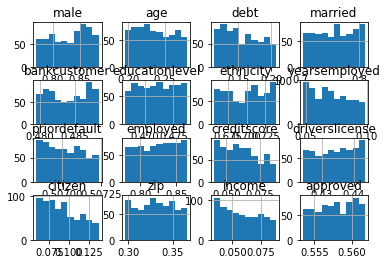

In [24]:

print(synth_data["approved"].describe())
synth_data.hist()
#dataset_test

In [25]:
eval_model(synth_data, dataset_test)

ValueError: Unknown label type: (array([0.5587489 , 0.55447656, 0.56024885, 0.5586329 , 0.5570742 ,
       0.55658066, 0.5549261 , 0.5603756 , 0.5583203 , 0.5535344 ,
       0.5603882 , 0.5590148 , 0.56173044, 0.56098497, 0.55389345,
       0.55767965, 0.5552601 , 0.5574704 , 0.5598663 , 0.5605698 ,
       0.55393195, 0.5591046 , 0.5578133 , 0.5605925 , 0.5575565 ,
       0.556381  , 0.5615247 , 0.5602342 , 0.5614434 , 0.55738   ,
       0.56022686, 0.559358  , 0.5561835 , 0.55451196, 0.55612266,
       0.5598869 , 0.55633414, 0.5535579 , 0.5545059 , 0.5605935 ,
       0.5569035 , 0.56036735, 0.5559883 , 0.5582772 , 0.55879605,
       0.55744684, 0.55359554, 0.5595398 , 0.55976313, 0.56088847,
       0.56143117, 0.55668986, 0.5565149 , 0.557443  , 0.55726796,
       0.5586145 , 0.557391  , 0.5618115 , 0.5559235 , 0.55358505,
       0.5543811 , 0.557767  , 0.56071025, 0.55512035, 0.56150615,
       0.55619466, 0.55497605, 0.560914  , 0.5551434 , 0.55601275,
       0.5556245 , 0.5613578 , 0.5600123 , 0.5599629 , 0.554797  ,
       0.5602208 , 0.55861115, 0.55809957, 0.5553944 , 0.5600437 ,
       0.5586317 , 0.5587404 , 0.56175214, 0.5539462 , 0.5602853 ,
       0.5578663 , 0.5610664 , 0.5575189 , 0.55946195, 0.56012905,
       0.55872643, 0.557847  , 0.55827194, 0.55774224, 0.5595005 ,
       0.55852604, 0.55408114, 0.55939853, 0.55646485, 0.5575281 ,
       0.56174666, 0.559673  , 0.55632514, 0.55839056, 0.5541888 ,
       0.558201  , 0.5588558 , 0.5606283 , 0.5595987 , 0.5610588 ,
       0.56165135, 0.558401  , 0.55356604, 0.5583445 , 0.56162006,
       0.55991495, 0.5535952 , 0.5603479 , 0.55870926, 0.557675  ,
       0.5542346 , 0.56035954, 0.55973405, 0.5543428 , 0.5548092 ,
       0.55774415, 0.5561686 , 0.5602972 , 0.55866945, 0.56144965,
       0.5579481 , 0.56057215, 0.560237  , 0.55882734, 0.5546523 ,
       0.55876595, 0.5593341 , 0.5561964 , 0.5569698 , 0.5565289 ,
       0.5615782 , 0.555826  , 0.5569379 , 0.5609093 , 0.5575067 ,
       0.56031936, 0.56087387, 0.56169456, 0.56030804, 0.56131935,
       0.5569797 , 0.56057644, 0.5584577 , 0.55763257, 0.5597914 ,
       0.56073743, 0.55726343, 0.55546266, 0.56171775, 0.5580143 ,
       0.55945283, 0.55507535, 0.55844516, 0.55992687, 0.56077087,
       0.5596066 , 0.5604195 , 0.5538899 , 0.5599501 , 0.5542514 ,
       0.56059223, 0.55971956, 0.5550381 , 0.5596401 , 0.5602364 ,
       0.5603894 , 0.5552178 , 0.5549753 , 0.55749536, 0.55569243,
       0.55836415, 0.5602595 , 0.5590236 , 0.55747795, 0.5543471 ,
       0.5565562 , 0.5572491 , 0.5544777 , 0.55621266, 0.5570176 ,
       0.5614866 , 0.55542815, 0.56174344, 0.5563874 , 0.55577123,
       0.5558008 , 0.56124055, 0.55820954, 0.55925184, 0.56088513,
       0.56157595, 0.5562509 , 0.5607451 , 0.5598591 , 0.5613715 ,
       0.55404824, 0.5604606 , 0.5585304 , 0.5582508 , 0.5607255 ,
       0.5554268 , 0.56003606, 0.55992395, 0.5562616 , 0.5551801 ,
       0.5584558 , 0.5537274 , 0.5611685 , 0.5595076 , 0.5601586 ,
       0.55779594, 0.5572904 , 0.5563931 , 0.558986  , 0.55629784,
       0.5561673 , 0.5562843 , 0.5613424 , 0.5590853 , 0.5572251 ,
       0.5607664 , 0.55981153, 0.56134236, 0.55819684, 0.55836844,
       0.5563519 , 0.5552371 , 0.55497134, 0.5612933 , 0.5614613 ,
       0.5609868 , 0.555128  , 0.5561232 , 0.5596409 , 0.5562992 ,
       0.55416095, 0.55643034, 0.55507696, 0.5583704 , 0.5583245 ,
       0.55585915, 0.5609771 , 0.56097686, 0.553602  , 0.5555826 ,
       0.55809325, 0.5610327 , 0.5559057 , 0.5585305 , 0.5565848 ,
       0.5594022 , 0.5582947 , 0.55360585, 0.55404   , 0.5543186 ,
       0.55635136, 0.5600159 , 0.56137925, 0.5584018 , 0.5616382 ,
       0.553845  , 0.5580575 , 0.5594667 , 0.56091243, 0.5608253 ,
       0.5549124 , 0.56029487, 0.5569144 , 0.55406606, 0.5588259 ,
       0.5582211 , 0.5540513 , 0.5584355 , 0.5577773 , 0.5545047 ,
       0.55441695, 0.56177247, 0.5604745 , 0.55523574, 0.5584513 ,
       0.55643636, 0.5546193 , 0.5549611 , 0.5617263 , 0.56175685,
       0.5558683 , 0.5534777 , 0.55808914, 0.55438364, 0.5578094 ,
       0.56042606, 0.5563032 , 0.5593155 , 0.55803835, 0.5570289 ,
       0.55599934, 0.561309  , 0.55775124, 0.55562407, 0.55614394,
       0.55981   , 0.56031734, 0.55840075, 0.56178266, 0.55723035,
       0.55656755, 0.5535143 , 0.5544135 , 0.5539106 , 0.5596324 ,
       0.56112397, 0.55391705, 0.5550539 , 0.55549014, 0.5616497 ,
       0.55616665, 0.5605556 , 0.5563031 , 0.5543344 , 0.5562254 ,
       0.553464  , 0.5593799 , 0.55560654, 0.5571543 , 0.5601921 ,
       0.55501825, 0.55687076, 0.5608427 , 0.556509  , 0.5553681 ,
       0.5537043 , 0.5578782 , 0.554674  , 0.5555459 , 0.5576278 ,
       0.55686474, 0.5587283 , 0.5536277 , 0.5598651 , 0.55376834,
       0.55781054, 0.55992407, 0.55864346, 0.55453396, 0.5598459 ,
       0.5549397 , 0.5545835 , 0.5610575 , 0.55830264, 0.55858105,
       0.5584909 , 0.5568275 , 0.559882  , 0.55429304, 0.55834293,
       0.55760676, 0.55971694, 0.5574685 , 0.55728805, 0.5575022 ,
       0.56021595, 0.5596639 , 0.5609887 , 0.55562514, 0.5579941 ,
       0.5579133 , 0.5597858 , 0.5615821 , 0.5600443 , 0.5595    ,
       0.55569094, 0.55380875, 0.5607463 , 0.557351  , 0.55907595,
       0.55630165, 0.5577702 , 0.55960816, 0.55487585, 0.55490017,
       0.5558911 , 0.5597161 , 0.5545639 , 0.5545427 , 0.56039447,
       0.55720294, 0.5608828 , 0.5615523 , 0.55455405, 0.56002903,
       0.5606893 , 0.5578061 , 0.5594775 , 0.5555008 , 0.5613277 ,
       0.5545511 , 0.55481935, 0.56055427, 0.5577304 , 0.55986667,
       0.55911016, 0.5550596 , 0.5603782 , 0.56142014, 0.56008375,
       0.56074035, 0.55426955, 0.5547037 , 0.56024486, 0.5550613 ,
       0.55992806, 0.5561027 , 0.5540893 , 0.5613902 , 0.55760354,
       0.56054604, 0.55873495, 0.5574936 , 0.55887586, 0.55953544,
       0.56070936, 0.5550278 , 0.55818814, 0.5578816 , 0.56011486,
       0.56055903, 0.55553097, 0.5559547 , 0.5537426 , 0.5564969 ,
       0.56171584, 0.5535185 , 0.56136274, 0.5566674 , 0.5583297 ,
       0.55747813, 0.55766064, 0.55443907, 0.5539951 , 0.55940866,
       0.5610093 , 0.55735993, 0.5578676 , 0.5589271 , 0.555617  ,
       0.5539429 , 0.5602556 , 0.55942917, 0.5584765 , 0.5574097 ,
       0.55776095, 0.5538702 , 0.55692196, 0.5584782 , 0.55437773,
       0.55963576, 0.56068105, 0.55754036, 0.558974  , 0.5594665 ,
       0.5601565 , 0.55639005, 0.556366  , 0.559234  , 0.5588303 ,
       0.56063974, 0.5545916 , 0.5586611 , 0.5561599 , 0.5553192 ,
       0.5568946 , 0.5540613 , 0.5545831 , 0.56170565, 0.56000215,
       0.55450475, 0.5563603 , 0.5565077 , 0.55945224, 0.55678827,
       0.55418587, 0.55629164, 0.5597781 , 0.55664045, 0.55722713,
       0.5586307 , 0.5566193 , 0.5611705 , 0.5603137 , 0.55982864,
       0.561311  , 0.560898  , 0.5542062 , 0.5560778 , 0.56142724,
       0.55702573, 0.55779284, 0.5555076 , 0.5594346 , 0.55861527,
       0.5553869 , 0.56137276, 0.55765647, 0.5601618 , 0.5564504 ,
       0.5563045 , 0.55592036, 0.55444044, 0.5611144 , 0.56096303,
       0.5617417 , 0.55641466, 0.55417514, 0.5552759 , 0.5551566 ,
       0.5535179 , 0.55433923, 0.5558076 , 0.55613804, 0.5602279 ,
       0.5567365 , 0.5596326 , 0.5575853 , 0.5614451 , 0.56044805,
       0.5617821 , 0.5590113 , 0.55751705, 0.5574897 , 0.55568427,
       0.55589384, 0.5545499 , 0.55955166, 0.5551463 , 0.55748814,
       0.55774194, 0.5541684 , 0.5536799 , 0.55759627, 0.55568314,
       0.5555609 , 0.55983263, 0.55806553, 0.5569924 , 0.5611032 ,
       0.5568792 , 0.5561318 , 0.5570809 , 0.55570143, 0.5557498 ,
       0.56035966, 0.556483  , 0.5541583 , 0.5576443 , 0.5540967 ,
       0.55424035, 0.5565467 , 0.5582558 , 0.55682456, 0.556476  ,
       0.5552163 , 0.5608216 , 0.55518854, 0.55727905, 0.5613988 ,
       0.5601787 , 0.5611755 , 0.5587114 , 0.55613273, 0.56016886,
       0.55849886, 0.555949  , 0.557308  , 0.55841166, 0.55839324,
       0.55643797, 0.5572791 , 0.56069803, 0.55674887, 0.5612797 ,
       0.5588234 , 0.55383664, 0.56118757, 0.5556515 , 0.5584961 ,
       0.5569181 , 0.56022954, 0.55905044, 0.5589839 , 0.5586449 ,
       0.56051725, 0.55569124, 0.5575231 , 0.5597048 , 0.5606285 ,
       0.55511993, 0.55777127, 0.5539861 , 0.55437297, 0.5606046 ,
       0.5537664 , 0.55523425, 0.55976355, 0.5574653 , 0.55829114,
       0.5543343 , 0.5601515 , 0.5566713 , 0.55959624, 0.5583124 ,
       0.5601659 , 0.56036544, 0.5581769 , 0.55592287, 0.55900174,
       0.55364645, 0.5548538 , 0.55773586, 0.5598764 , 0.55667967,
       0.5573874 , 0.5549394 , 0.5541588 , 0.56170726, 0.55943006,
       0.5571408 , 0.5574859 , 0.55621076, 0.5615379 , 0.55767024,
       0.55745417, 0.5558431 , 0.55990493, 0.55349666, 0.5585787 ,
       0.5546613 , 0.5603664 , 0.55974376, 0.55793065, 0.5582907 ,
       0.553716  , 0.5540359 , 0.5593455 , 0.55790144, 0.55433285,
       0.55770177, 0.5589712 , 0.5611834 , 0.5573176 , 0.55417705,
       0.56180364, 0.55710846, 0.5593838 , 0.5556372 , 0.5600007 ,
       0.55489284, 0.55841076, 0.5614841 , 0.55404156, 0.55370724,
       0.5607057 , 0.55479544, 0.5578962 , 0.5609782 , 0.56058955,
       0.5602938 , 0.55619025, 0.55863726], dtype=float32),)